In [3]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

from numpy import linalg as la

# Initial blending plotter
For the Euler and shallow water vortices

In [46]:
# Do we plot SWE or Euler vortex?
swe = False

## Comparison with imbalanced initial conditions

75.98432399020805 -93.71574634570169


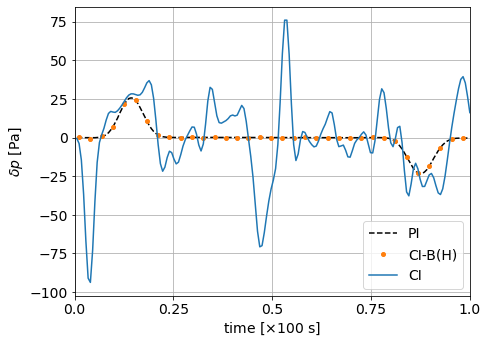

In [47]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']

et = 1.0
N = 1

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'lake_noib_imbal'
    sfx2a = 'imbal_noib'
    sfx2b = 'imbal_full_ib-16'
    sfx2c = 'imbal_half_ib-0'
    sfx3 = 'imbal_noib'
    
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
    sfx1 = 'psinc_imbal_noib'
    sfx2a = 'comp_imbal_noib'
    sfx2b = 'comp_imbal_full_ib-16'
    sfx2c = 'comp_imbal_half_ib-0'
    sfx3 = 'comp_imbal_noib'
    
times = np.arange(0,176)
t_axs = np.linspace(0.0,1.0,5)
t_pos = np.linspace(0,175,5)
probe_loc = [32,32]
l_typ = 'WINDOW_STEP'

attr_labels = pt.labels_increment()

# load pickled instances of data used in simulation
fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
file.close()

if swe:
    p_ref = ud.d_ref #* 100
else:
    p_ref = ud.p_ref
Msq = ud.Msq


def p_converter(ens,rhoY,ud,sfx):
    dp2n = np.array([ (at_t - at_t.mean()) * ud.Msq for at_t in ens ])
    kernel = np.ones((2,2))
    dp2c = np.array([signal.fftconvolve(item, kernel, mode='valid') / kernel.sum() for item in dp2n])

    if 'psinc' in sfx:
        P0 = (rhoY**(ud.gamm-1.0) + dp2c)**(1.0/(ud.gamm-1.0))
        p = P0**(ud.gamm)
    else:
        P0 = (rhoY**(ud.gamm-1.0) - dp2c)**(1.0/(ud.gamm-1.0))
        p = rhoY**(ud.gamm) - P0**(ud.gamm)
        
    p *= ud.p_ref
    return p

def h_converter(ens,ud,sfx):
    ens *= p_ref
    return ens

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=diff)
    if swe:
        ens = ens[:,:,0,:] # project 3D to 2D
        ens = ens[1:]
        p = h_converter(ens,ud,sfx)
    else:
        ens = ens[1:]
        rhoY = rhoY[1:]
        p = p_converter(ens,rhoY,ud,sfx)
    
    probe = p[:,probe_loc[0],probe_loc[1]]
    probe = probe[1:] - probe[:-1]
#     if attribute == 'p2_nodes':
#     probe = ens[:,probe_loc[0],probe_loc[1]] * p_ref * Msq
#     probe = probe[1:] # remove first time-step

    label = sfx + '_' + attribute
    return probe

pls = []

for i,attribute in enumerate(attributes):
    diff = False
#     diff = True if attribute == 'p2_nodes' else False

    p1 = get_ens(sfx1, diff, attribute)
    p2b = get_ens(sfx2b, diff, attribute)
    p2c = get_ens(sfx2c, diff, attribute)
    p3 = get_ens(sfx3, diff, attribute)

    fs = (7,5) # fs used in draft
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)

    times = times[1:]
    
    ref = 'lake' if swe else 'psinc'
    full = 'SWE' if swe else 'comp'
    ic = 'imbal.' if 'imbal' in sfx3 else 'bal.'
    l1 = '%s, imbal. IC' %(ref)
    l1 = 'PI' if not swe else 'LK'
    l2c = r'%s, imbal. IC, w/ blending ($\pi_{half}$)' %full
    l2c = 'CI-B(H)' if not swe else 'SW-B(H)'
    l2b = r'%s, imbal. IC, w/ blending ($\pi_{full}$)' %full
    l3 = '%s, %s IC w/o blending' %(full, ic)
    l3 = 'CI' if not swe else 'SW'
    ic = ic[:-1]

    ax.plot(times, p1, 'k--', label=l1)
#     ax.plot(times, p2b, 'C0o', ms=4, markevery=4, label=l2b)
    ax.plot(times[1:], p2c[1:], 'C1o', ms=4, markevery=5, label=l2c)
    ax.plot(times, p3, 'C0', label=l3)
    print(p3.max(), p3.min())

    ax.set_xlim([times[0],times[-1]])
    if swe:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta h$ [m]')
        ax.ticklabel_format(style='sci',scilimits=(-2,-2),axis='both')
        
    else:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta p$ [Pa]')
        
    ax.set_xticks(t_pos)
    ax.set_xticklabels(t_axs)
    ax.grid()
    ax.legend()
    pl.img.tight_layout()
    
    fn = 'swe' if swe else 'euler'
    pl.save_fig('./output/%s_w_%s' %(fn, ic))

## Comparison with balanced initial conditions

probe_loc = (32, 32)
blending (half) - bal. sol.: 0.036713
blending (full) - bal. sol.: 0.046748


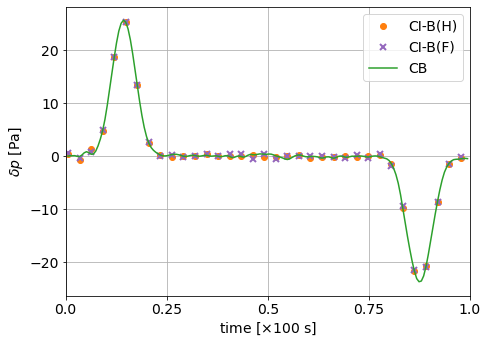

In [48]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']

et = 1.0
N = 1

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
    
    sfx1 = 'lake_noib_imbal'
    sfx2a = 'imbal_noib'
    # sfx2b = 'comp_imbal_full_tpz_ib-16'
    # sfx2c = 'comp_imbal_half_tpz_ib-0'
    sfx2b = 'imbal_full_ib-16'
    sfx2c = 'imbal_half_ib-0'
    sfx3 = 'bal_noib'
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    sfx1 = 'psinc_imbal_noib'
    sfx2a = 'comp_imbal_noib'
#     sfx2b = 'comp_imbal_full_tpz_ib-16'
#     sfx2c = 'comp_imbal_half_tpz_ib-0'
    sfx2b = 'comp_imbal_full_ib-16'
    sfx2c = 'comp_imbal_half_ib-0'
    sfx3 = 'comp_bal_noib'
    
times = np.arange(0,175)
# if swe:
#     times = np.arange(0.0,1.05,0.05)[1:]
# else:
#     times = np.arange(0.0,1.005,0.005)[1:]
t_axs = np.linspace(0.0,1.0,5)
t_pos = np.linspace(0,175,5)
# t_pos = t_axs
probe_loc = [32,32]
l_typ = 'WINDOW_STEP'
# l_typ = 'TIME'

attr_labels = pt.labels_increment()

# sfx3 = 'truthgen'
# sfx1 = sfx3

# load pickled instances of data used in simulation
fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
file.close()

if swe:
    p_ref = ud.d_ref
else:
    p_ref = ud.p_ref
Msq = ud.Msq

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=diff)
    if swe:
        ens = ens[:,:,0,:] # project 3D to 2D
        ens = ens[1:]
        p = h_converter(ens,ud,sfx)
    else:
        ens = ens[1:]
        rhoY = rhoY[1:]
        p = p_converter(ens,rhoY,ud,sfx)
    
#     if attribute == 'p2_nodes':
#     probe = ens[:,probe_loc[0],probe_loc[1]] * p_ref * Msq
    probe = p[:,probe_loc[0],probe_loc[1]]
    probe = probe[1:] - probe[:-1]


    label = sfx + '_' + attribute
    return probe

pls = []

for i,attribute in enumerate(attributes):
    diff = False

    p1 = get_ens(sfx1, diff, attribute)
    p2b = get_ens(sfx2b, diff, attribute)
    p2c = get_ens(sfx2c, diff, attribute)
    p3 = get_ens(sfx3, diff, attribute)

    fs = (7,5) # fs used in draft
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)

    times = times[1:]
    
    ref = 'lake' if swe else 'psinc'
    full = 'SWE' if swe else 'comp'
    ic = 'imbal.' if 'imbal' in sfx3 else 'bal.'
    l1 = '%s, imbal. IC' %(ref)
    l2c = r'%s, imbal. IC, w/ blending ($\pi_{half}$)' %full
    l2c = 'CI-B(H)' if not swe else 'SW-B(H)'
    l2b = r'%s, imbal. IC, w/ blending ($\pi_{full}$)' %full
    l2b = 'CI-B(F)' if not swe else 'SW-B(F)'
    l3 = '%s, %s IC w/o blending' %(full, ic)
    l3 = 'CB' if not swe else 'SWB'
    ic = ic[:-1]

#     ax.plot(times, p1, 'k', label=l1)
    ax.plot(times, p2c, 'C1o', ms=6, markevery=5, label=l2c)
    ax.plot(times, p2b, 'C4x', ms=6, markevery=5, mew=2.0, label=l2b)
    ax.plot(times, p3, 'C2', label=l3)

    ax.set_xlim([times[0],times[-1]])
    if swe:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta h$ [m]')
        ax.ticklabel_format(style='sci',scilimits=(-2,-2),axis='both')
    else:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta p$ [Pa]')
        
    ax.set_xticks(t_pos)
    ax.set_xticklabels(t_axs)
    ax.grid()
    ax.legend()
    pl.img.tight_layout()
    
    fn = 'swe' if swe else 'euler'
    pl.save_fig('./output/%s_w_%s' %(fn, ic))
    
    print("====================")
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
    print("blending (half) - bal. sol.: %.6f" %(la.norm(p2c-p3)/la.norm(p3)))
    print("blending (full) - bal. sol.: %.6f" %(la.norm(p2b-p3)/la.norm(p3)))

# Reply to Reviewer #2, specific comment 8
## Note that the input files used here are not generated by the `result_gen.py` file

In [7]:
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
attributes = ['p2_nodes']

et = 1.0
N = 1

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    # path to output directory
    py_directory = "../../%s/" %directory
    
    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
    
times = np.arange(0,176)
t_axs = np.linspace(0.0,1.0,5)
t_pos = np.linspace(0,175,5)
probe_loc = [32,32]
l_typ = 'WINDOW_STEP'

attr_labels = pt.labels_increment()

sfx1 = 'psinc_noib'
sfx2a = 'comp_imbal_noib'
sfx2b = 'debug_8_ib-0'
sfx2c = 'debug_1_ib-0'
sfx3 = 'comp_bal_noib'

# load pickled instances of data used in simulation
fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
file.close()

if swe:
    p_ref = ud.h_ref * 100
else:
    p_ref = ud.p_ref
Msq = ud.Msq

def get_ens(sfx , diff, attribute):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff)
    rhoY = tc.get_ensemble(times, N, 'rhoY', sfx, label_type=l_typ, avg=True, diff=diff)
    if swe:
        ens = ens[:,:,0,:] # project 3D to 2D
    else:
        ens = ens[1:]
        rhoY = rhoY[1:]
        p = p_converter(ens,rhoY,ud)
    
#     if attribute == 'p2_nodes':
#     probe = ens[:,probe_loc[0],probe_loc[1]] * p_ref * Msq
    probe = p[:,probe_loc[0],probe_loc[1]]
    probe = probe[1:] - probe[:-1]


    label = sfx + '_' + attribute
    return probe

pls = []

for i,attribute in enumerate(attributes):
    diff = False

    p1 = get_ens(sfx1, diff, attribute)
    p2b = get_ens(sfx2b, diff, attribute)
    p2c = get_ens(sfx2c, diff, attribute)
    p3 = get_ens(sfx3, diff, attribute)

    fs = (8,4) # fs used in draft
    pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=1,nrows=1)
    ax = pl.get_ax(i)

    times = times[1:]
    
    ref = 'lake' if swe else 'psinc'
    full = 'SWE' if swe else 'comp'
    ic = 'imbal.' if 'imbal' in sfx3 else 'bal.'
    l1 = '%s, imbal. IC' %(ref)
    l2c = r'%s, imbal. IC, w/ blending ($\pi_{half}$)' %full
    l2b = r'%s, imbal. IC, w/ blending ($\pi_{full}$)' %full
    l3 = '%s, %s IC w/o blending' %(full, ic)
    ic = ic[:-1]

#     ax.plot(times, p1, 'k', label=l1)
    ax.plot(times, p2c, 'C1o', ms=4, markevery=4, label=l2c)
    ax.plot(times, p2b, 'C4o', ms=4, markevery=4, label=l2b)
    ax.plot(times, p3, 'C2', label=l3)

    ax.set_xlim([times[0],times[-1]])
    if swe:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta h$ [$\times 10^{-2}$ m]')
    else:
        ax.set_xlabel(r'time [$\times 100$ s]')
        ax.set_ylabel(r'$\delta p^\prime$ [Pa]')
        
    ax.set_xticks(t_pos)
    ax.set_xticklabels(t_axs)
    ax.grid()
    ax.legend()
    pl.img.tight_layout()
    
    fn = 'swe' if swe else 'euler'
    pl.save_fig('./output/%s_w_%s' %(fn, ic))
    
    print("====================")
    print("probe_loc = (%i, %i)" %(probe_loc[0],probe_loc[1]))
    print("%s - psinc: %.6f" %(sfx2c, la.norm(p2c-p1)/la.norm(p1)))
    print("%s - psinc: %.6f" %(sfx2b, la.norm(p2b-p1)/la.norm(p1)))

TypeError: p_converter() missing 1 required positional argument: 'sfx'